### Prepare the data

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = loadmat('..\epi_data\ke_data\chb01_mat\chb01_03.mat')
EEGSig = data['data']#[:, :256*30*3]

EEGSig.shape

(23, 921600)

In [ ]:
fs = 256
segment_length = fs * 30
start_indices = np.arange(0, EEGSig.shape[1], segment_length)
last_segment_end = min(start_indices[-1] + segment_length, EEGSig.shape[1])
start_indices = np.append(start_indices, last_segment_end)

desired_width_px = 2560
desired_height_px = 1680
dpi = 72
fig_width = int(desired_width_px / dpi)
fig_height = int(desired_height_px / dpi)

# Create a figure and a grid of subplots
num_rows = 23
num_cols = 1
for si in range(len(start_indices) - 1):
    segment_start = start_indices[si]
    segment_end = start_indices[si + 1]
    segment = EEGSig[:, segment_start:segment_end]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    # Iterate through each row of data and plot it in a separate subplot
    for i in range(num_rows):
        axes[i].plot(segment[i, :], linewidth=0.5, color='black')
        axes[i].axis('off')
        axes[i].tick_params(axis='both', which='both', length=0)
    #plt.savefig(f'..\epi_data\eegfig\\train\\01_03_{int(segment_start/fs)}_0.png')
    #plt.show()

In [ ]:
suizers_begin = 2996
suizers_end = 3036
step_length = fs * 1
segment_length = fs * 30
start_indices = np.arange((suizers_begin-10) * fs, (suizers_end + 15) * fs, step_length)
for si in range(len(start_indices) - 1):
    segment_start = start_indices[si]
    segment_end = start_indices[si] + segment_length
    segment = EEGSig[:, segment_start:segment_end]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    # Iterate through each row of data and plot it in a separate subplot
    for i in range(num_rows):
        axes[i].plot(segment[i, :], linewidth=0.5, color='black')
        axes[i].axis('off')
        axes[i].tick_params(axis='both', which='both', length=0)
    #plt.savefig(f'..\epi_data\eegfig\\01_03_{int(segment_start/fs)}_1.png')
    #plt.show()

### CNN Model

In [45]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

In [86]:
lr = 0.001 # learning_rate
batch_size = 20 # we will use mini-batch method
epochs = 10 # How much to train a model

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [87]:
train_dir = '..\epi_data\eegfig\\train'
test_dir = '..\epi_data\eegfig\\test'
os.listdir(train_dir)[:5]

['01_03_0_0.png',
 '01_03_1020_0.png',
 '01_03_1050_0.png',
 '01_03_1080_0.png',
 '01_03_1110_0.png']

In [88]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.png'))
test_list = glob.glob(os.path.join(test_dir, '*.png'))
len(train_list), len(test_list), train_list[:5]

(161,
 10,
 ['..\\epi_data\\eegfig\\train\\01_03_0_0.png',
  '..\\epi_data\\eegfig\\train\\01_03_1020_0.png',
  '..\\epi_data\\eegfig\\train\\01_03_1050_0.png',
  '..\\epi_data\\eegfig\\train\\01_03_1080_0.png',
  '..\\epi_data\\eegfig\\train\\01_03_1110_0.png'])

In [16]:
train_list[1].split('.')[-2][-1]

'0'

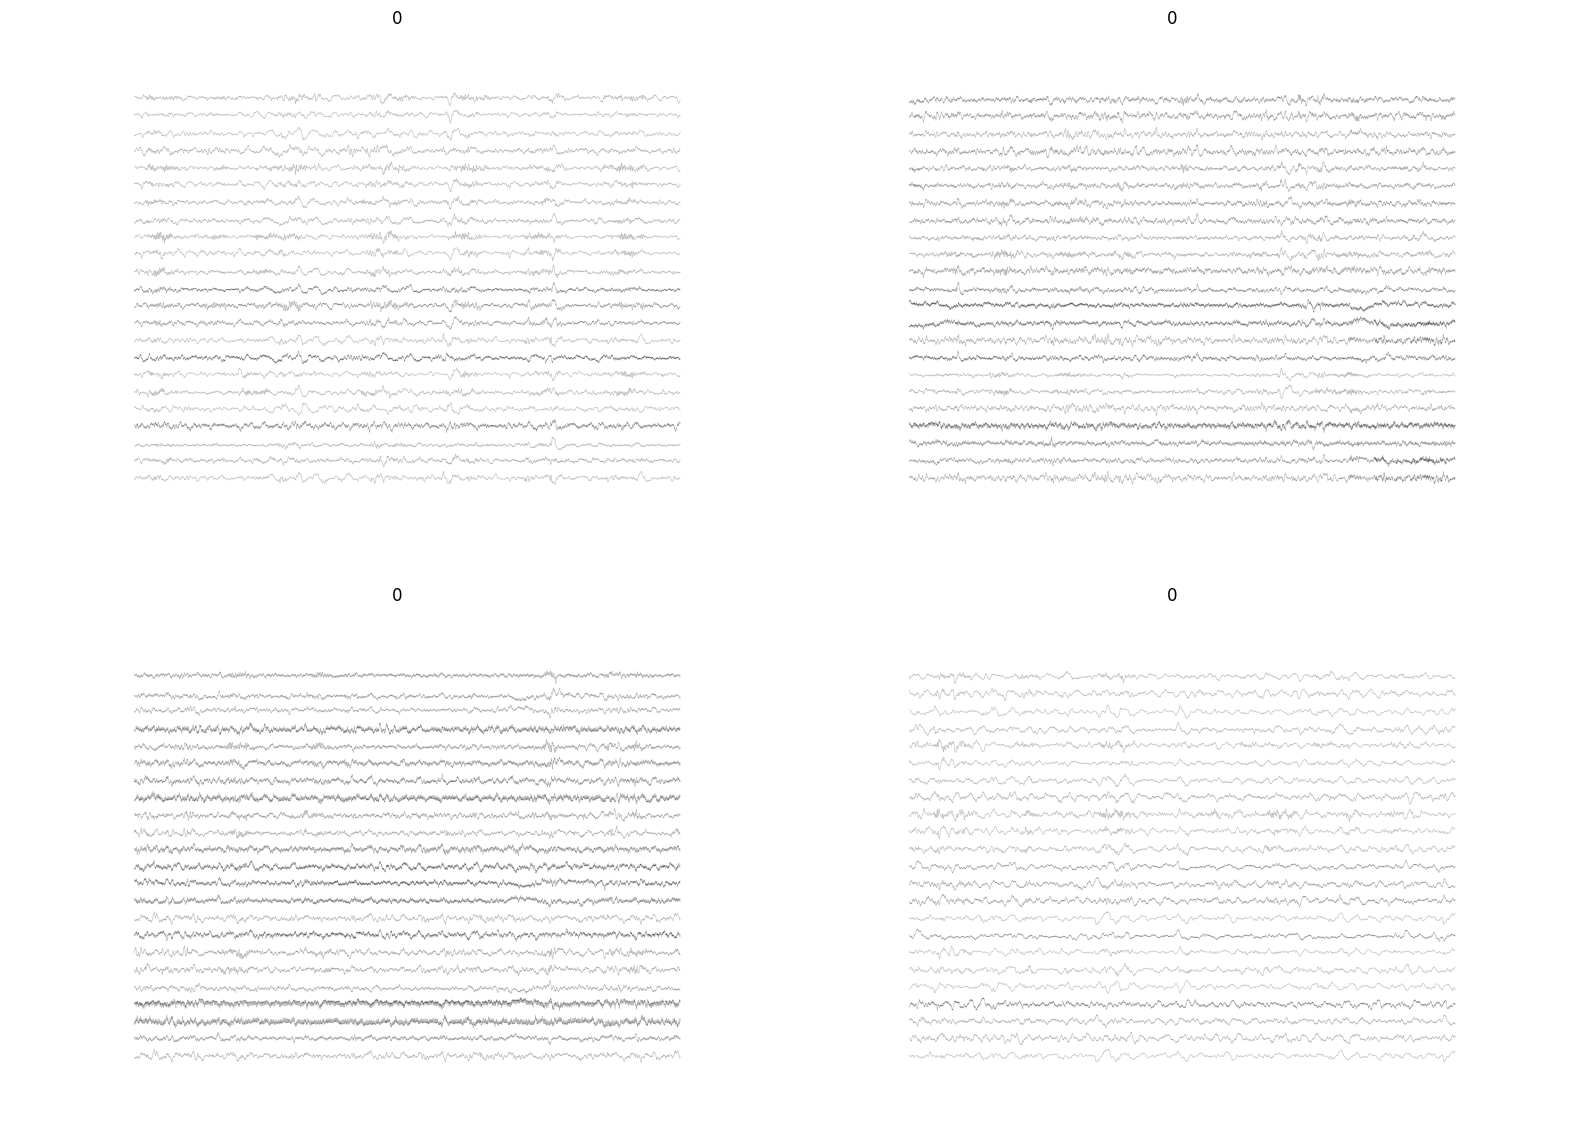

In [50]:
from PIL import Image
random_idx = np.random.randint(1,len(train_list),size=4)
fig = plt.figure(figsize=(20, 15))
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,2,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    ax.axis('off')
    ax.tick_params(left=False, right=False, top=False, bottom=False)
    ax.set_title(f"{train_list[idx].split('.')[-2][-1]}")
    i+=1

plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [89]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [90]:
# data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [91]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('.')[-2][-1]
        #if label == 'dog':
            #label=1
        #elif label == 'cat':
            #label=0
            
        return img_transformed,label

In [92]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [93]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [94]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
#check our images shape
train_data[0][0].shape

128 7
33 2


torch.Size([4, 224, 224])

In [95]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(4,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [96]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [97]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [98]:
for batch_idx, (data, label) in enumerate(train_loader):
    #label = [l.split('\\')[-1] for l in label]
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}")
    print(f"Label shape: {label}")
    if batch_idx == 0:
        break

Batch 1:
Data shape: torch.Size([20, 4, 224, 224])
Label shape: ('1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0')


In [99]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        #class_names = [l.split('\\')[-1] for l in label]
        #class_to_label = {'dog': 0, 'cat': 1}
        label_list = [int(l) for l in label]
        label = torch.tensor(label_list, dtype=torch.long).to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            #class_names = [l.split('\\')[-1] for l in label]
            #class_to_label = {'dog': 0, 'cat': 1}
            label_list = [int(l) for l in label]
            label = torch.tensor(label_list, dtype=torch.long).to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        

Epoch : 1, train accuracy : 0.625, train loss : 0.6625407338142395
Epoch : 1, val_accuracy : 0.7365384697914124, val_loss : 0.5727773904800415
Epoch : 2, train accuracy : 0.7000000476837158, train loss : 0.6068387031555176
Epoch : 2, val_accuracy : 0.759615421295166, val_loss : 0.5322539806365967
Epoch : 3, train accuracy : 0.7392857074737549, train loss : 0.5570750832557678
Epoch : 3, val_accuracy : 0.7846153974533081, val_loss : 0.4838036894798279
Epoch : 4, train accuracy : 0.7571428418159485, train loss : 0.503824770450592
Epoch : 4, val_accuracy : 0.7711538672447205, val_loss : 0.3974037766456604
Epoch : 5, train accuracy : 0.7607142329216003, train loss : 0.4727216362953186
Epoch : 5, val_accuracy : 0.8230769634246826, val_loss : 0.3510262668132782
Epoch : 6, train accuracy : 0.8499999642372131, train loss : 0.432799369096756
Epoch : 6, val_accuracy : 0.884615421295166, val_loss : 0.28673356771469116
Epoch : 7, train accuracy : 0.8964285850524902, train loss : 0.31414270401000977

In [121]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        fileid = [fi for fi in fileid]
        dog_probs += list(zip(fileid, preds_list))

dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('0', 0.010842724703252316),
 ('1', 0.008341558277606964),
 ('2', 0.034618280827999115),
 ('3', 0.11925261467695236),
 ('4', 0.22798579931259155),
 ('5', 0.009355288930237293),
 ('6', 0.017852598801255226),
 ('7', 0.9759907126426697),
 ('8', 0.022339479997754097),
 ('9', 0.43970122933387756)]

In [122]:
idx = list(map(lambda x: x[0],dog_probs))
testid = [810, 1560, 1860, 2310,2550, 2640, 2820, 3006, 3120, 3180]
prob = list(map(lambda x: x[1],dog_probs))
submission = pd.DataFrame({'id':idx,'label':prob, 'testid': testid})
# submission.to_csv('result.csv',index=False)
submission

,id,label,testid
0,0,0.010843,810
1,1,0.008342,1560
2,2,0.034618,1860
3,3,0.119253,2310
4,4,0.227986,2550
5,5,0.009355,2640
6,6,0.017853,2820
7,7,0.975991,3006
8,8,0.022339,3120
9,9,0.439701,3180


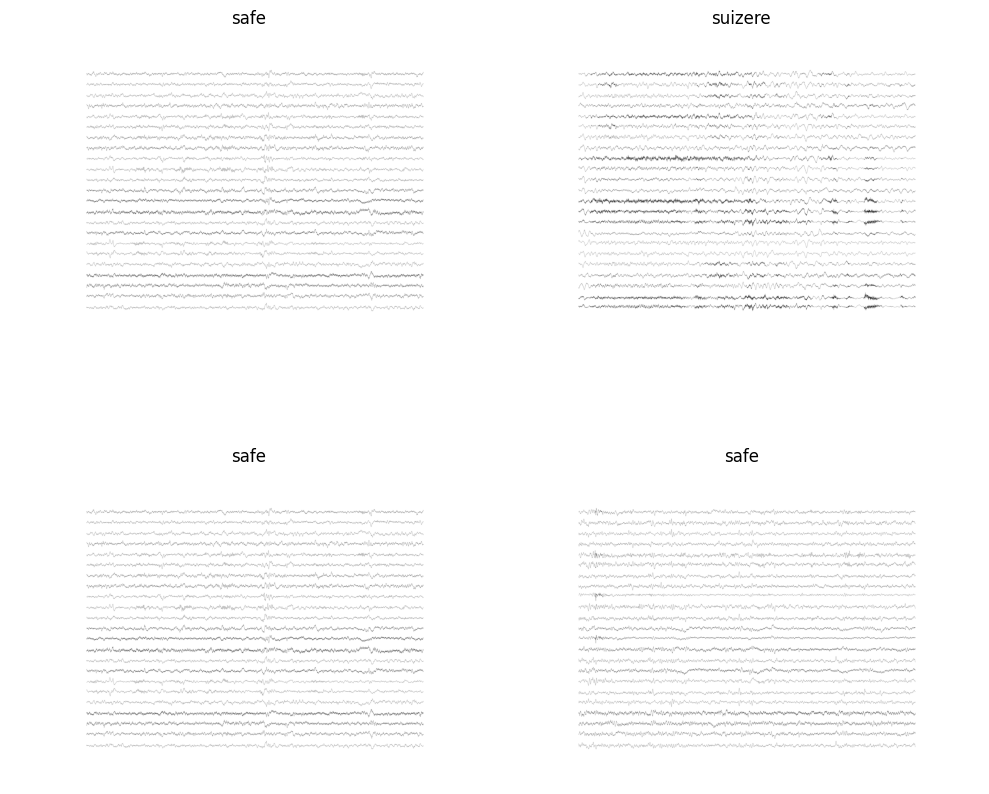

In [133]:
import random

id_list = []
class_ = {0: 'safe', 1: 'suizere'}
# Define the figure size and DPI for higher resolution
fig_width = 10  # Width of the figure in inches

fig_height = 10  # Height of the figure in inches
dpi = 100  # DPI (dots per inch)

fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height), dpi=dpi, facecolor='w')
plt.subplots_adjust(wspace=0, hspace=0)
for ax in axes.ravel():
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
    test_id = submission['testid'][int(i)]
    img_path = os.path.join(test_dir, f"01_03_{test_id}_{i}.png")
    img = Image.open(img_path)
    
    # Clear previous content in the subplot
    ax.clear()
    
    # Set the aspect ratio to maintain the image's original aspect ratio
    aspect_ratio = img.width / img.height
    
    # Resize the subplot based on the aspect ratio and desired width
    subplot_width = 4  # Adjust the width as needed
    subplot_height = subplot_width / aspect_ratio
    ax.set_aspect(aspect_ratio)
    
    # Display the image
    ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title(class_[label])
    ax.imshow(img)

plt.tight_layout()  # Ensure tight layout
plt.show()